__Author:__ Bogdan Bintu

__Email:__ bbintu@g.harvard.edu

__Date:__ 3/4/2020

In [1]:
#Imports
import glob,os,sys
from copy import deepcopy
import matplotlib.pylab as plt
import numpy as np
import cv2
import cPickle as pickle
from scipy.spatial import ConvexHull
from scipy.spatial.distance import cdist
from tqdm import tqdm_notebook as tqdm

#Internal packages
import Fitting_v4 as ft
import workers_cells_v3 as wkc

#usefull functions

def normalzie_im(im,sz=30,ratio=False):
    """
    normalize a 3d image <im> by subtracting local gaussian blur of std <sz>
    """
    im_ = np.array(im,dtype=np.float32)
    im_blur = np.array([cv2.blur(im__,(sz,sz)) for im__ in im_])
    if ratio:
        im_ =im_/im_blur
    else:
        im_ =(im_-im_blur)/np.median(im_blur)
    return im_
def get_standard_seeds(im,th_stds = 4,sz_blur=30,npix=2,npts=None):
    """
    Calculates the local maximum (with size npix) in 3d that are <th_stds> standard deviations above 
    the local <sz_blur> gaussian backgrounds.
    Returns a sorted list of local maxima with z,x,y, and birghtness info
    """
    #im_norm = im/np.median(im)#normalzie_im(im,sz_blur)
    im_norm = normalzie_im(im,sz_blur)
    hcutoff = np.std(im_norm)*th_stds
    z,x,y = np.where(im_norm>hcutoff)
    h_im = im_norm[z,x,y]
    sz,sx,sy = im_norm.shape
    keep = h_im>-np.inf
    deltas = range(-npix,npix+1)
    for deltax in deltas:
        for deltay in deltas:
            for deltaz in deltas:
                if (np.abs(deltax)+np.abs(deltay)+np.abs(deltaz))>0:
                    keep &= (h_im>im_norm[(z+deltaz)%sz,(x+deltax)%sx,(y+deltay)%sy])
    zf,xf,yf = z[keep],x[keep],y[keep]
    hf = im_norm[zf,xf,yf]
    inds = np.argsort(hf)[::-1]
    if npts is not None:
        inds = inds[:npts]
    centers_zxyh = np.array([zf[inds],xf[inds],yf[inds],hf[inds]]).T
    return centers_zxyh



def in_hull(pt,hull,offset=10**(-10)):
    """
    #checks whether a point pt is within the convex hull hull
    pts = np.random.random([100,3])
    conv = ConvexHull(pts)
    in_hull(pts[29],conv)
    """
    
    surfs = hull.equations
    check = np.all([surface_signed_dist(elem,pt=pt)<offset for elem in surfs]) 
    return check
def surface_signed_dist(surf,pt):
    #checks whether the 3D point pt is on the positive or negative side of the surface defined by equation surf
    #this condition can be stated as [dot(normal,pt)+offset<0]
    #also returns the actual perpendicular distance
    normal = surf[:-1]
    offset = surf[-1]
    t_ = np.dot(normal,pt)
    return t_+offset
def get_drift(im_beadsT,im_beadsF):
    tzxy = ft.fft3d_from2d(im_beadsT,im_beadsF,gb=5,max_disp=150,plt_val=False,return_cor=False)
    M = cdist(zxyhF[:,:3],zxyhT[:,:3]-tzxy,'chebyshev')
    i1 = np.arange(M.shape[0])
    i2 = np.argmin(M,axis=1)
    keep = M[i1,i2]<2
    i1 = i1[keep]
    i2 = i2[keep]
    seedsF = zxyhF[i1,:3]
    seedsT = zxyhT[i2,:3]
    psF = ft.fast_fit_big_image(im_beadsF,seedsF,radius_fit = 4,avoid_neigbors=False,verbose=False,recenter=False,better_fit=False)
    psT = ft.fast_fit_big_image(im_beadsT,seedsT,radius_fit = 4,avoid_neigbors=False,verbose=False,recenter=False,better_fit=False)
    drift = np.median((psT-psF)[:,1:4],0)
    return drift

def in_hullF(pt,hull,offset=10**(-10)):
    """
    #checks whether a point pt is within the convex hull hull
    pts = np.random.random([100,3])
    conv = ConvexHull(pts)
    in_hull(pts[29],conv)
    """
    surfs = hull.equations
    normal = surfs[:,:-1]
    offset_ = surfs[:,[-1]]
    t_ = np.dot(normal,pt.T)+offset_
    check = np.all(t_<offset,axis=0)
    return check


In [2]:
%matplotlib inline

In [5]:
plt_val = False
post_analysis_folder = r'E:\Bogdan_Temp\7_27_2019_IMR90RNA-Analysis-refitted\cell_decoding_refitted_v2' #analysis folder with cell segmentation etc.
folder_NUC = r'\\dolly\Raw_data\Bogdan\7_27_2019_IMR90RNA\Ab3Nucleolus' #Nucelolus datafolder
folder_SC = r'\\dolly\Raw_data\Bogdan\7_27_2019_IMR90RNA\Ab2SC35' #Speckle datafolder
folder_ref =  r'\\dolly\Raw_data\Bogdan\7_27_2019_IMR90RNA\H0B,B' # DAPI folder. Everything is aligned to this dataset
#Get the already analyzed data
fls = np.sort([fl for fl in glob.glob(post_analysis_folder+os.sep+'*.pkl') if '_Ab.pkl' not in fl and '_Ab_ims.pkl' not in fl])

pad_scope = 10

In [ ]:
for fl in tqdm(fls):
    out_fl = fl.replace('.pkl','_Ab.pkl')
    if True:#not os.path.exists(out_fl):
        try:
            dic = pickle.load(open(fl,'rb'))
            dic_ims={}
            #get coordinates & other info
            coordsi = np.array([reg for chr_hom in dic['dna_zxy'] for chr_r in chr_hom for reg in chr_r],dtype=float)
            coordsigood = coordsi[~np.isnan(coordsi[:,0])]
            pd=10
            zxym,zxyM = np.nanmin(coordsi,0).astype(int)-pd,np.nanmax(coordsi,0).astype(int)+pd
            zxym[zxym<0]=0
            fov = dic['cell'].split('__cell')[0]

            #Nucleolus
            #Align two subdaxes.
            dax_flT = folder_NUC+os.sep+fov+'.dax'
            dax_flF = folder_ref+os.sep+fov+'.dax'
            im_beadsT = wkc.get_dax_im(dax_flT,2,3,zxym,zxyM,pad=pad_scope)
            zxyhT = get_standard_seeds(im_beadsT,th_stds = 4,sz_blur=30,npix=3,npts=500)
            im_beadsF = wkc.get_dax_im(dax_flF,3,5,zxym,zxyM,pad=pad_scope)
            zxyhF = get_standard_seeds(im_beadsF,th_stds = 4,sz_blur=30,npix=3,npts=500)
            drift = get_drift(im_beadsT,im_beadsF)
            DNA_to_image = -dic.get('rna_dna_drift',0)-drift+zxym
            #sample the image
            #reload(wkc)
            im_T = wkc.get_dax_im(dax_flT,0,3,zxym,zxyM,pad=pad_scope,no_med=True)
            im_T_ = normalzie_im(im_T,sz=100,ratio=True)
            im_T_ = im_T_-1
            im_T_/=np.median(np.abs(im_T_))
            th=6
            zxy_struct = np.array(np.where(im_T_>th)).T
            zxy_struct_ = zxy_struct+DNA_to_image
            hull = ConvexHull(coordsigood)
            zxy_struct_ = zxy_struct_[in_hullF(zxy_struct_,hull)]

            dic_ims['im_NUC']=im_T.astype(np.uint16)
            dic['zxy_NUC']=zxy_struct_
            dic['zxyDNA_to_NUC']=DNA_to_image

            if plt_val:
                plt.figure()
                plt.imshow(np.max(im_T[:],0),cmap='gray')
                plt.contour(np.max(im_T_>th,0),0.5,colors=['r'])

            #Splicesomes
            #Align two subdaxes.
            dax_flT = folder_SC+os.sep+fov+'.dax'
            dax_flF = folder_ref+os.sep+fov+'.dax'
            im_beadsT = wkc.get_dax_im(dax_flT,2,3,zxym,zxyM,pad=pad_scope)
            zxyhT = get_standard_seeds(im_beadsT,th_stds = 4,sz_blur=30,npix=3,npts=500)
            im_beadsF = wkc.get_dax_im(dax_flF,3,5,zxym,zxyM,pad=pad_scope)
            zxyhF = get_standard_seeds(im_beadsF,th_stds = 4,sz_blur=30,npix=3,npts=500)
            drift = get_drift(im_beadsT,im_beadsF)
            DNA_to_image = -dic.get('rna_dna_drift',0)-drift+zxym
            #sample the image
            reload(wkc)
            im_T = wkc.get_dax_im(dax_flT,0,3,zxym,zxyM,pad=pad_scope,no_med=True)
            coordsigood = coordsi[~np.isnan(coordsi[:,0])]
            coords_struct = coordsigood-DNA_to_image
            im_T_ = normalzie_im(im_T,sz=50,ratio=True)
            im_T_ = im_T_-1
            im_T_/=np.median(np.abs(im_T_))
            th=6
            zxy_struct = np.array(np.where(im_T_>th)).T
            zxy_struct_ = zxy_struct+DNA_to_image
            hull = ConvexHull(coordsigood)
            zxy_struct_ = zxy_struct_[in_hullF(zxy_struct_,hull)]

            dic_ims['im_SC']=im_T.astype(np.uint16)
            dic['zxy_SC']=zxy_struct_
            dic['zxyDNA_to_SC']=DNA_to_image
            if plt_val:
                plt.figure()
                plt.imshow(np.max(im_T[:],0),cmap='gray')
                plt.contour(np.max(im_T_>th,0),0.5,colors=['r'])
                #plt.plot(coords_struct[:,2],coords_struct[:,1],'x')

            pickle.dump(dic_ims,open(out_fl.replace('_Ab.pkl','_Ab_ims.pkl'),'wb'))
            pickle.dump(dic,open(out_fl,'wb'))
        except:
            print("Failed",out_fl)

(1312.317777368772, 1468.2879750504364, 543.8939212757272, 804.6669341005397)

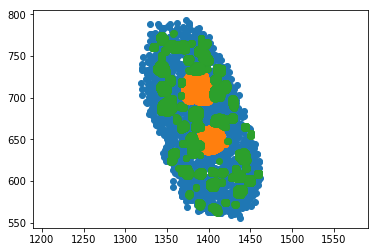

In [6]:
plt.figure()
plt.plot(coordsigood[:,2],coordsigood[:,1],'o') #dna data points
plt.plot(dic['zxy_NUC'][:,2],dic['zxy_NUC'][:,1],'o') #dna nucleolus data points
plt.plot(dic['zxy_SC'][:,2],dic['zxy_SC'][:,1],'o') #speckle data points

plt.axis('equal')